In [1]:
# 2023 Gabriel J. Diaz @ RIT

import os
import sys
import numpy as np
import av
import logging
import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pathlib import Path, PurePath


logger = logging.getLogger(__name__)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [2]:
    
# file_path = Path('D:\\Github\\retinal_flow_toolkit\\videos\\Yoyo-LVRA.mp4')

file_path = Path('D:\\Github\\retinal_flow_toolkit\\videos\\cb1.mp4')


In [3]:
container_in = av.open(file_path.as_posix())
average_fps = container_in.streams.video[0].average_rate
num_frames = container_in.streams.video[0].frames
time_base = container_in.streams.video[0].time_base
encoded_frame_count = container_in.streams.video[0].encoded_frame_count
# container_in.sort_dts = True
# container_in.flush_packets = True

container_out = av.open('vid_out.mp4', mode="w", timeout = None)

# container_out.flush_packets = True

stream = container_out.add_stream("libx264", framerate = average_fps)
#stream = container_out.add_stream("h264_nvenc", framerate = average_fps) Throws pts/dts related errors.
#stream = container_out.add_stream("hevc_nvenc", framerate = average_fps) Throws pts/dts related errors.

stream.options["crf"] = "20"
stream.pix_fmt = container_in.streams.video[0].pix_fmt
stream.time_base = container_in.streams.video[0].time_base

In [4]:
# stream.codec_context.time_base = container_in.streams.video[0].codec_context.time_base
# stream.codec_context.skip_frame = "NONKEY"

pts = []
dts = []
frame_time_base = []
relative_time = []

# for raw_frame in container_in.decode(video=0):
for raw_frame in tqdm(container_in.decode(video=0), desc="Working.", unit= 'frames',total = num_frames):
        
    pts.append(raw_frame.pts)
    dts.append(raw_frame.dts)
    frame_time_base.append(raw_frame.time_base)
    relative_time.append( np.float32(raw_frame.pts * raw_frame.time_base) )
    
    for packet in stream.encode(raw_frame):
#         packet.stream = container_in.streams.video[0]
#         packet.time_base = raw_frame.time_base
#         packet.pts = raw_frame.pts
#     #         packet.dts = raw_frame.dts # encoding dts throws error. 
        container_out.mux(packet)

# # Flush stream
for packet in stream.encode():
#     packet.stream = container_in.streams.video[0]
#     packet.time_base = raw_frame.time_base
    container_out.mux(packet)

container_out.close()
container_in.close()

Working.: 100%|█████████████████████████████████████████████████████████████| 92694/92694 [04:36<00:00, 335.50frames/s]


In [5]:
# container_in = av.open('vid_out.mp4')
container_in = av.open('vid_out.mp4', mode="r", timeout = None)
time_base_out = container_in.streams.video[0].time_base
num_frames = container_in.streams.video[0].frames

pts_out = []
dts_out = []
frame_time_base_out = []
relative_time_out = []

count = 0
#for raw_frame in container_in.decode(video=0):
for raw_frame in tqdm(container_in.decode(video=0), desc="Working.", unit= 'frames',total = num_frames):

    pts_out.append(raw_frame.pts)
    dts_out.append(raw_frame.dts)
    frame_time_base_out.append(raw_frame.time_base)
    relative_time_out.append( np.float32(raw_frame.pts * raw_frame.time_base) )
    count = count+1
    
container_in.close()
print( count)

Working.: 100%|████████████████████████████████████████████████████████████| 92694/92694 [00:24<00:00, 3760.37frames/s]

92694


In [6]:
print('Len pts:     {}'.format(len(pts)))
print('Len pts_out: {}'.format(len(pts_out)))

Len pts:     92694
Len pts_out: 92694


C:\Users\gabri\AppData\Local\Temp\ipykernel_4816\3017845406.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)


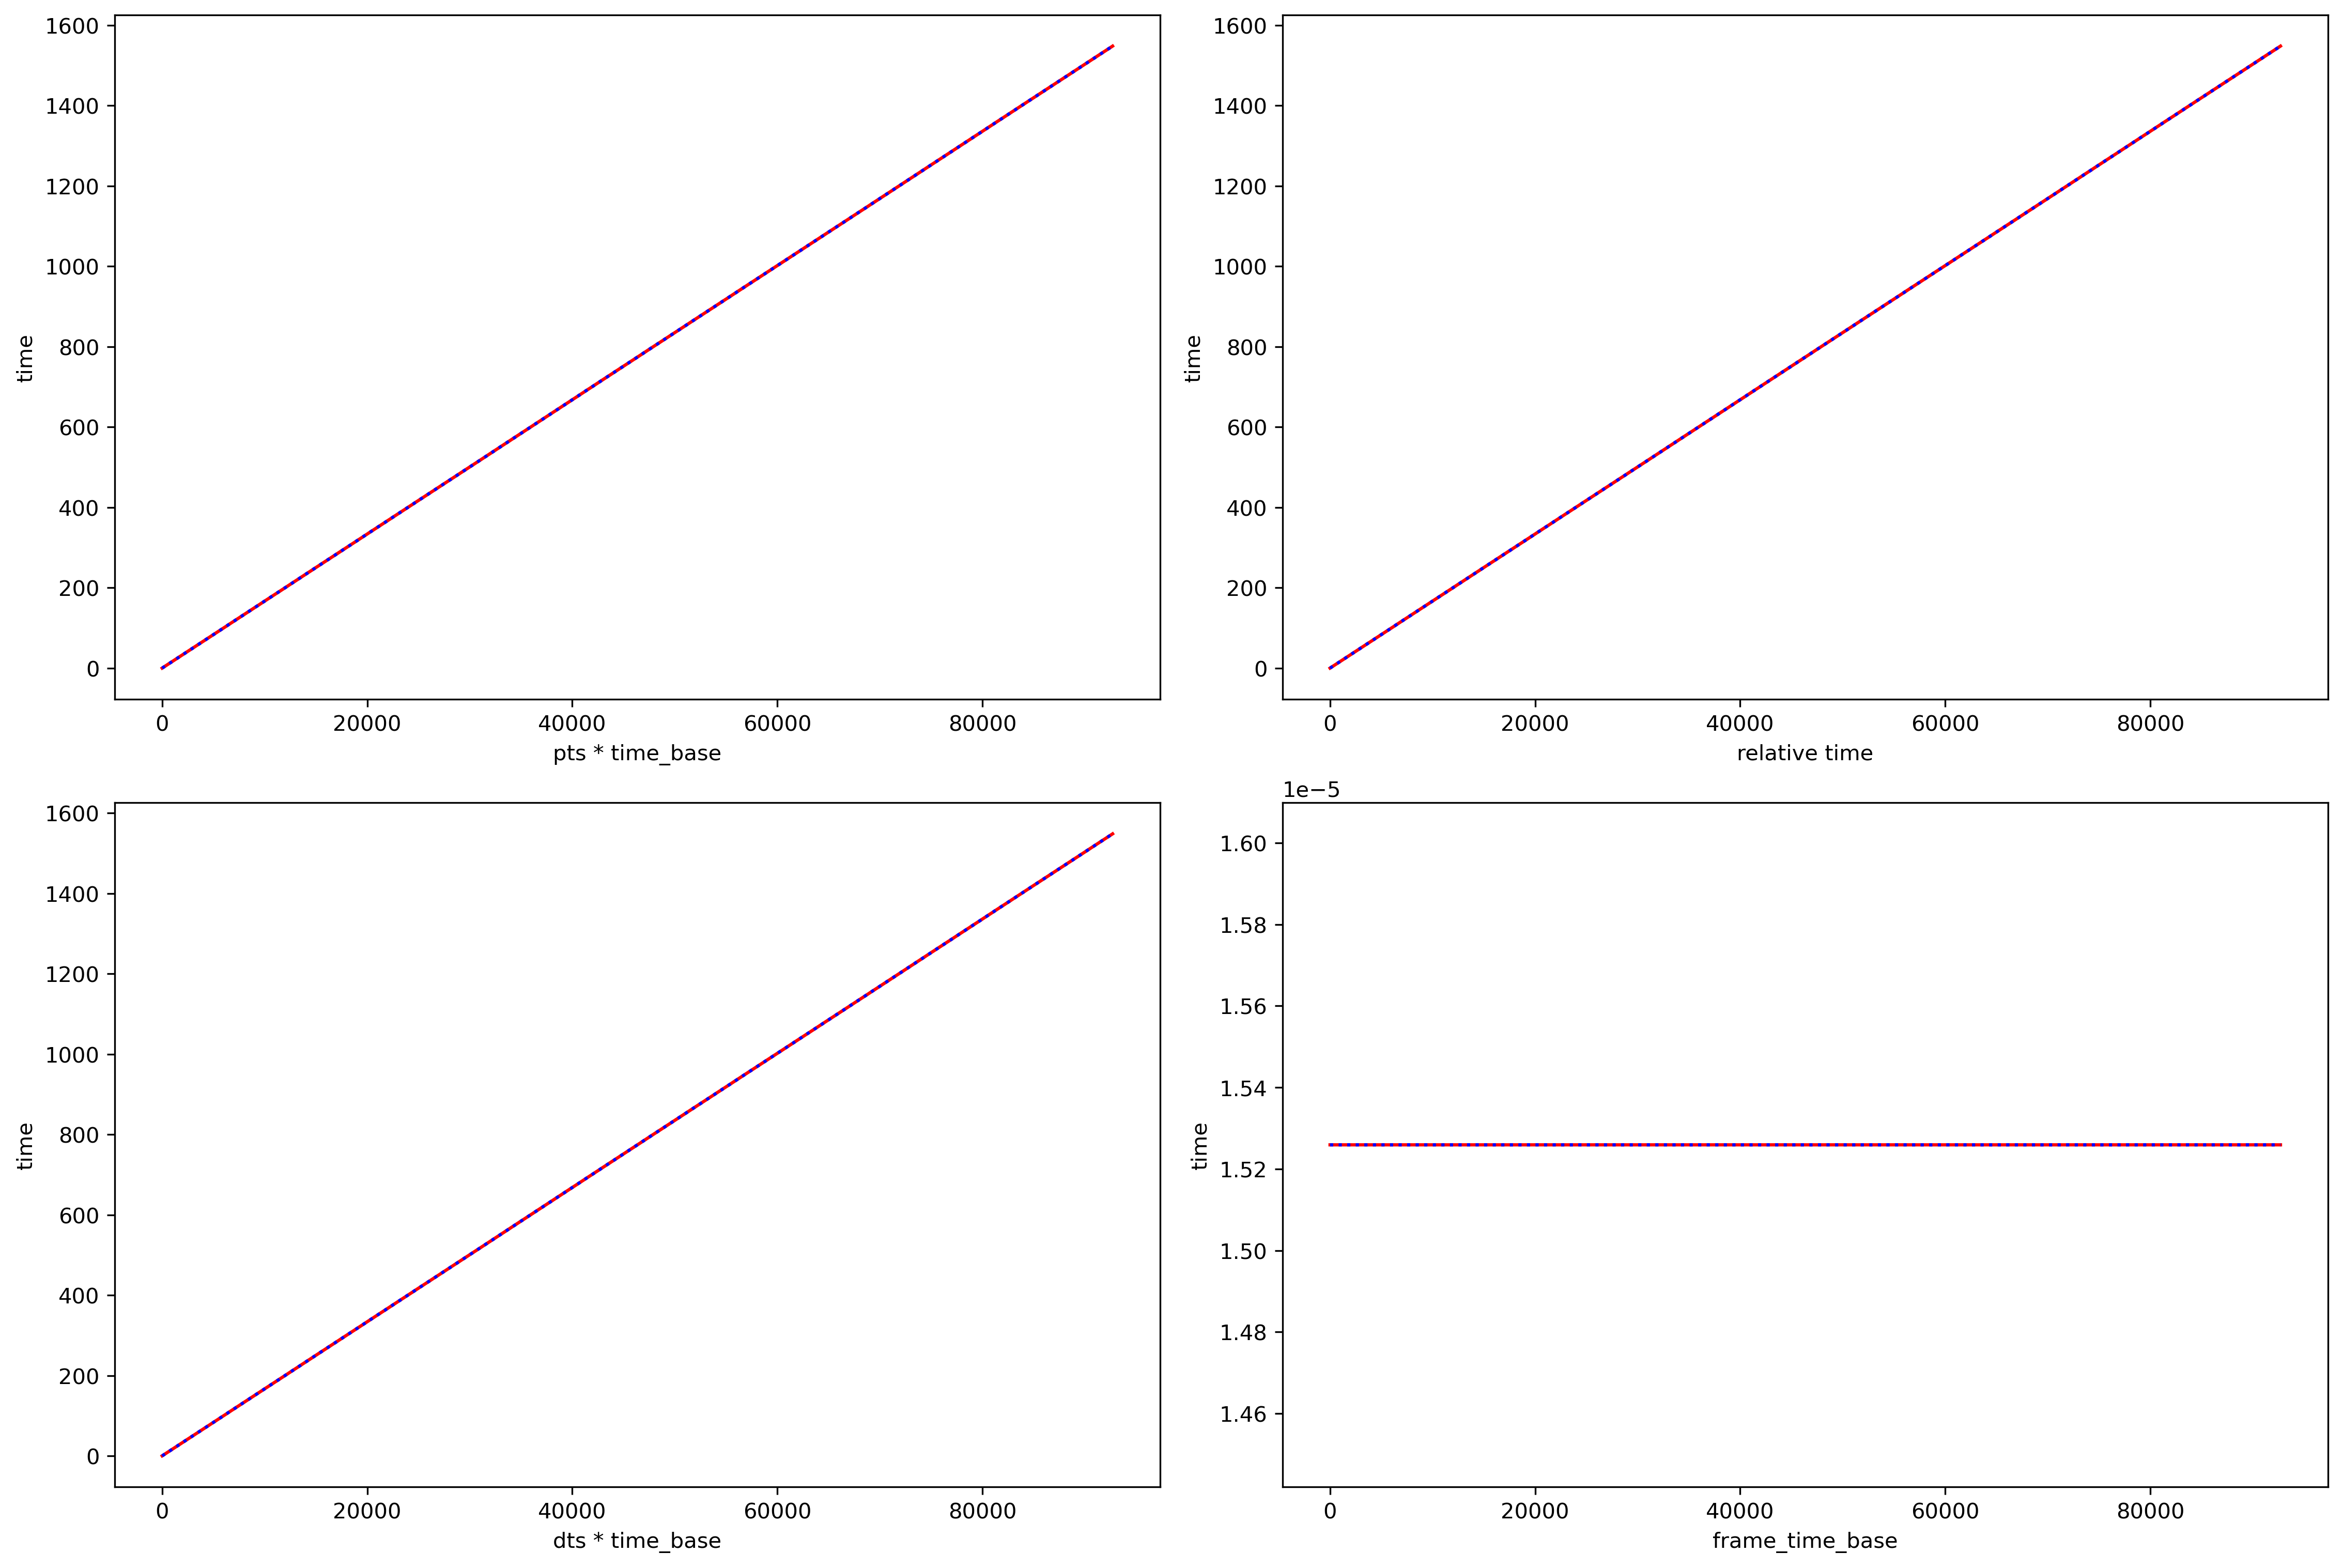

In [7]:
dts = np.array(dts,dtype=np.float32)
dts_out = np.array(dts_out,dtype=np.float32)

fig, ax = plt.subplots(figsize=(15, 10), layout='constrained',dpi=300)

plt.subplot(2,2,1)
plt.plot(np.arange(0,len(pts)) ,np.array(pts) * float(time_base),'r')
plt.plot(np.arange(0,len(pts_out)) ,np.array(pts_out) * float(time_base_out),':b')
plt.ylabel('time')
plt.xlabel('pts * time_base')

plt.subplot(2,2,2)
plt.plot( relative_time,'r')
plt.plot( relative_time_out,':b')
plt.ylabel('time')
plt.xlabel('relative time')

plt.subplot(2,2,3)
plt.plot(np.arange(0,len(dts)) ,np.array(dts) * float(time_base),'r')
plt.plot(np.arange(0,len(dts_out)) ,np.array(dts_out) * float(time_base_out),':b')
plt.ylabel('time')
plt.xlabel('dts * time_base')


plt.subplot(2,2,4)
plt.plot(np.arange(0,len(frame_time_base)),frame_time_base,'r')
plt.plot(np.arange(0,len(frame_time_base_out)),frame_time_base_out,':b')
plt.ylabel('time')
plt.xlabel('frame_time_base')

plt.savefig( 'frame_timings.png')

pickle_out = 'frame_timings.pkl'
dbfile = open(pickle_out, 'wb')
data_out_dict = {"pts":pts, "pts_out":pts_out,"dts":dts,"dts_out":dts_out,"relative_time":relative_time, "relative_time_out":relative_time_out}
pickle.dump( data_out_dict, dbfile)
dbfile.close()

Text(0.5, 0, 'pts * time_base')

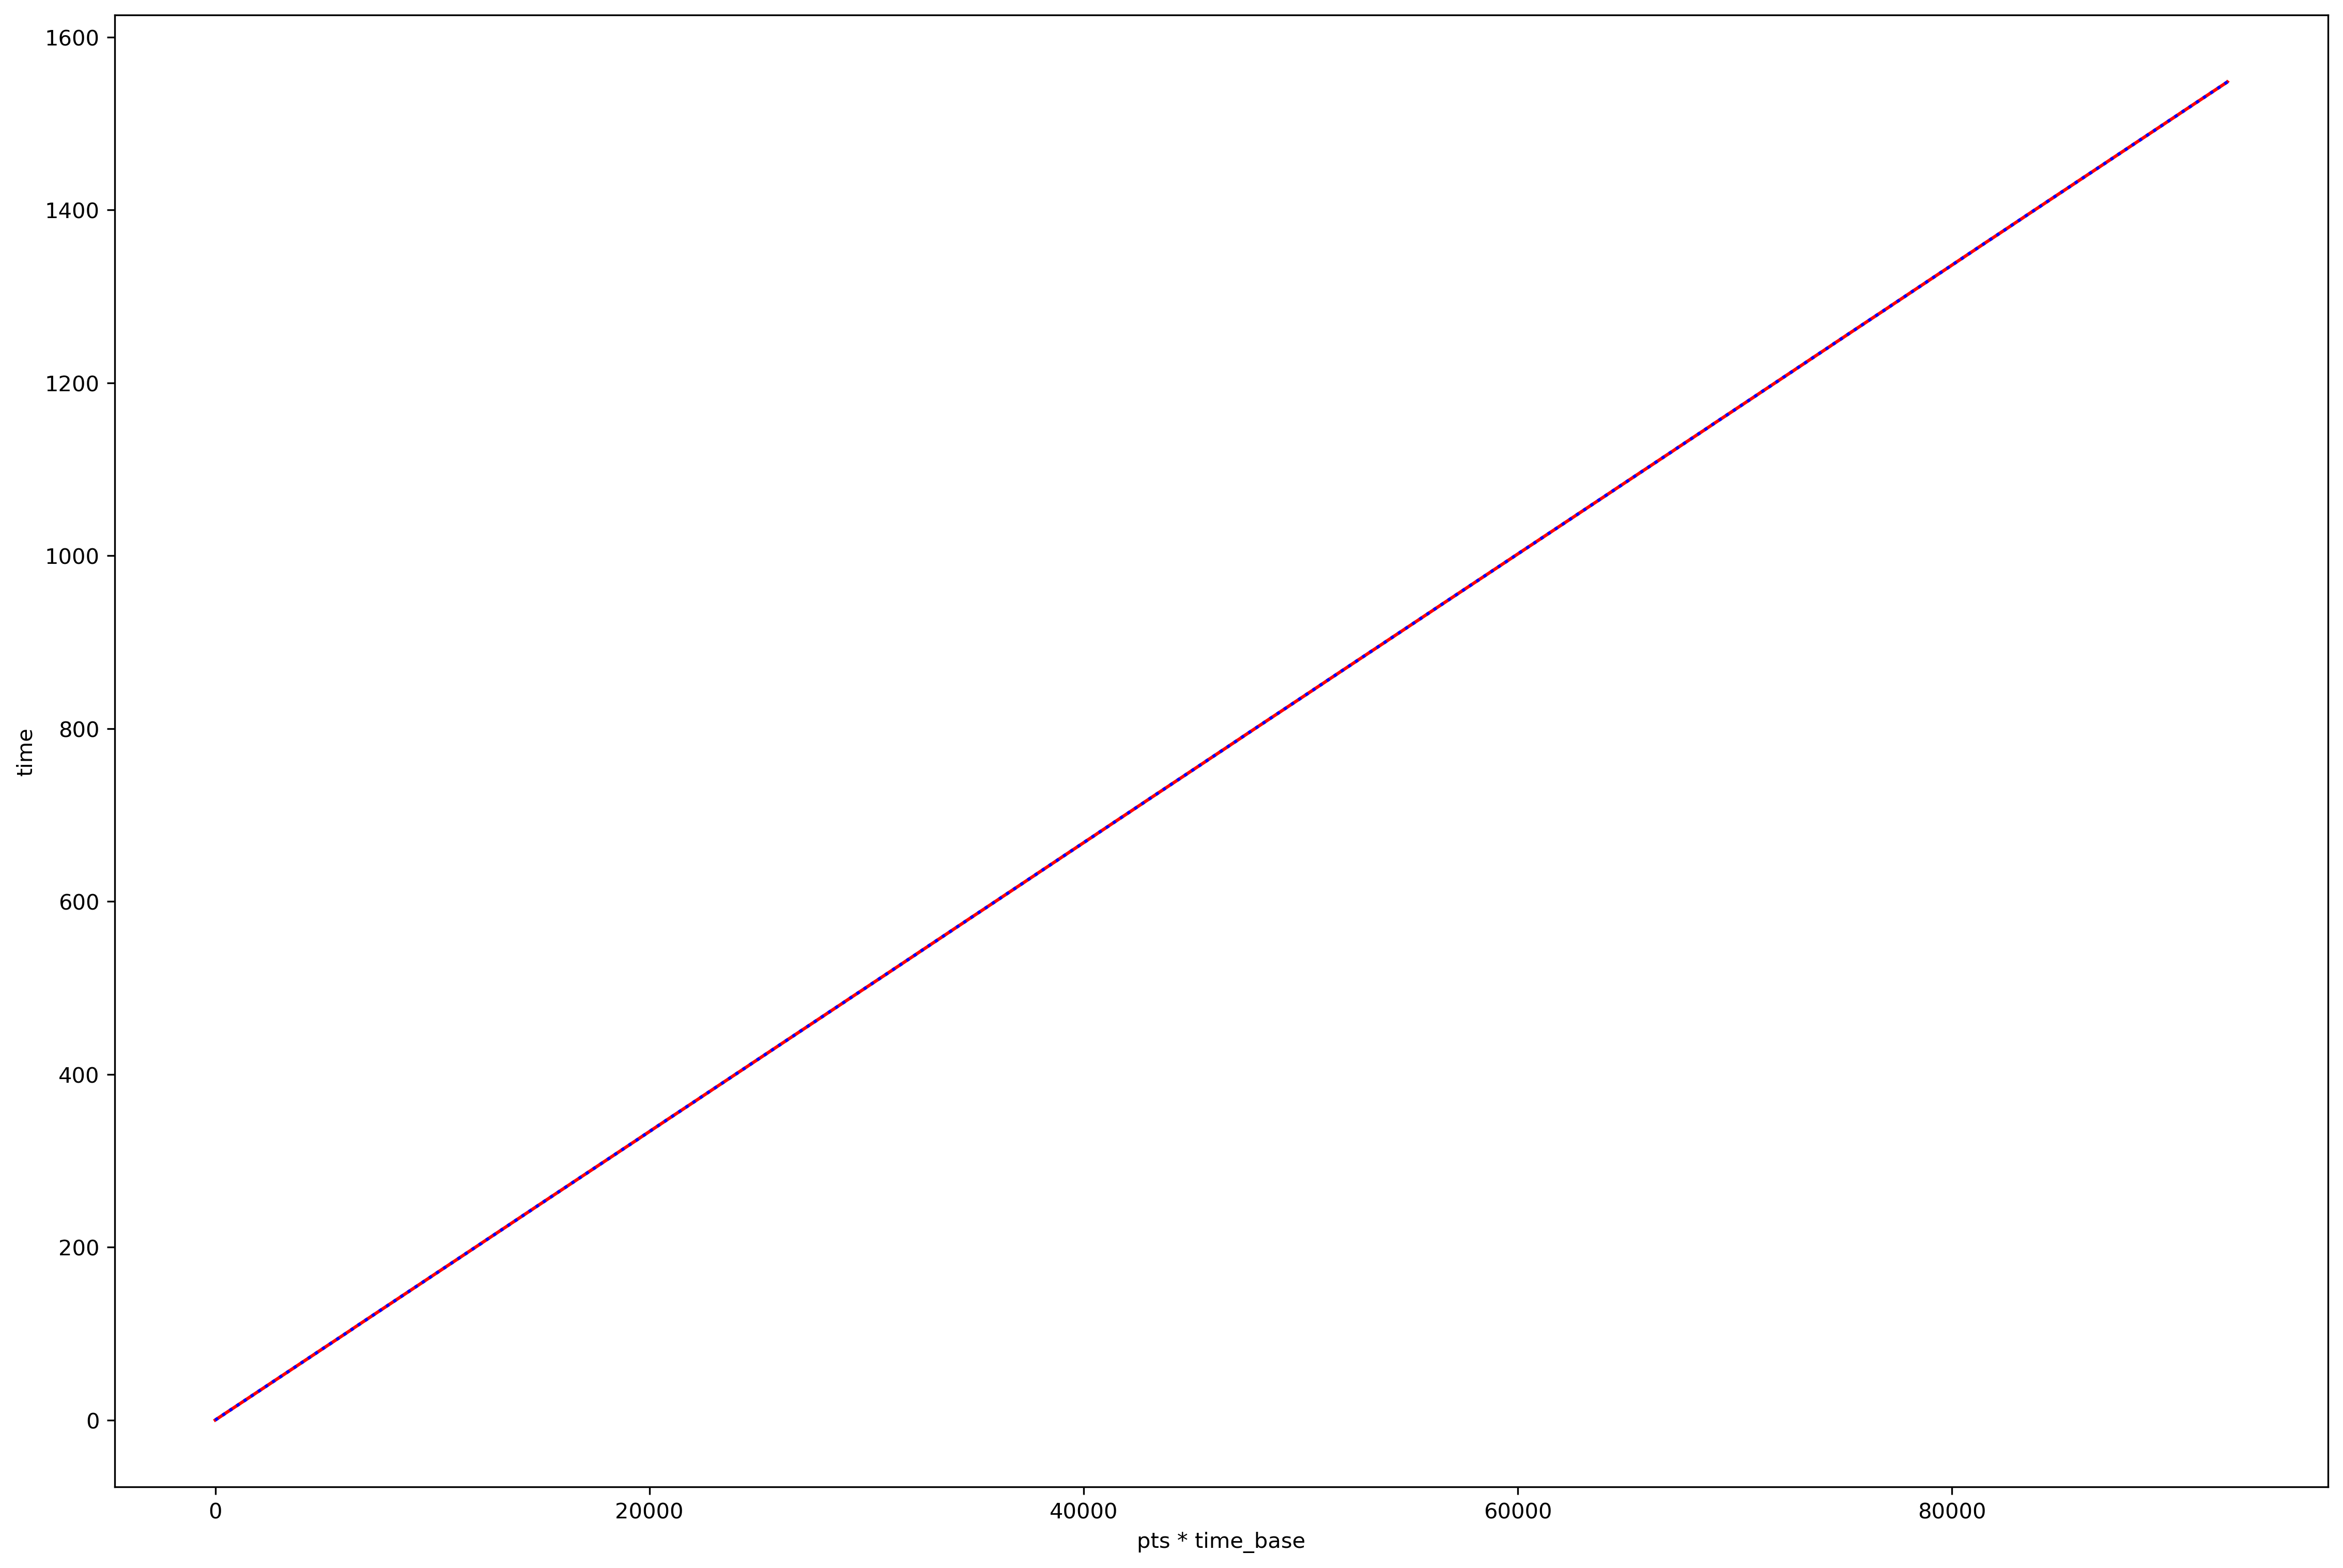

In [8]:
dts = np.array(dts,dtype=np.float32)
dts_out = np.array(dts_out,dtype=np.float32)

fig, ax = plt.subplots(figsize=(15, 10), layout='constrained',dpi=300)

# plt.subplot(2,2,1)
plt.plot(np.arange(0,len(pts)) ,np.array(pts) * float(time_base),'r')

plt.plot(np.arange(0,len(pts_out)) ,np.array(pts_out) * float(time_base_out),':b')
plt.ylabel('time')
plt.xlabel('pts * time_base')


In [9]:
np.array(pts[:5]) * float(time_base)

array([0.00300603, 0.01409934, 0.03607233, 0.06175326, 0.06205844])

In [10]:
np.array(pts_out[:5]) * float(time_base)

array([0.00300603, 0.01409934, 0.03607233, 0.06175326, 0.06205844])

In [11]:
pts[0] * float(time_base)

0.0030060273136491952

In [12]:
pts_out[0] * float(time_base)

0.0030060273136491952

In [13]:
container_in = av.open(file_path.as_posix())
container_out = av.open('vid_out.mp4')

In [14]:

print('Time base A ' + str( container_in.streams.video[0].time_base))
print('Time base B ' + str(container_out.streams.video[0].time_base))

print('Num frames A ' + str(container_in.streams.video[0].frames))
print('Num frames B ' + str(container_out.streams.video[0].frames))

print('Avg rate A ' + str(container_in.streams.video[0].average_rate))
print('Avg rate B ' + str(container_out.streams.video[0].average_rate))

print('Start time A: ' + str(container_in.start_time))
print('Start time B: ' + str(container_out.start_time))

print('Duration A: ' + str(container_in.duration))
print('Duration B: ' + str(container_out.duration))


Time base A 1/65535
Time base B 1/65535
Num frames A 92694
Num frames B 92694
Avg rate A 2084411164/34813627
Avg rate B 872365058/14570229
Start time A: 3006
Start time B: 3006
Duration A: 1548166000
Duration B: 1548211000


In [15]:
container_out.streams.video[0]

<av.VideoStream #0 h264, yuv420p 640x480 at 0x23e2c019270>

In [16]:
container_in.streams.video[0]

<av.VideoStream #0 mpeg4, yuv420p 640x480 at 0x23e2c00ebd0>

In [17]:

container_out.close()
container_in.close()